In [1]:
import uncertainties
from uncertainties.umath import * # sin(), etc.
from uncertainties import ufloat
from uncertainties import unumpy, umath
import math
from scipy.optimize import minimize
from scipy import stats
import math
from autograd import hessian
import autograd.numpy as np
import glob
from matplotlib import pyplot as plt
import os

In [3]:
import time
import numpy as np
arglist = []
triger = int(time.time())
np.random.seed(triger)
seeds = []
for i in range(1001,2001):
    seeds_temp = {}
    for decay in ['b2dpi_LL', 'b2dpi_DD', 'b2dk_LL', 'b2dk_DD']:
        for comp in ['sig', 'comb', 'misid', 'low', 'low_misid', 'low_Bs2DKPi', 'B_M']:
            for charge in ['p', 'm']:
		
                seeds_temp[decay+'_'+comp+'_'+charge] = np.random.randint(10, 1e6)
    seeds[i] = seeds_temp

IndexError: list assignment index out of range

In [10]:
result_files = []
failed_files = []
for i in range(1, 501):
    result_file = f"/shared/scratch/pc24403/sig_only_6p/bm/simfit_output_{i}.txt"
    if os.path.exists(result_file):
        with open(result_file) as f:
            content = f.read()    
            result_files.append(result_file)
    else:
        failed_files.append(i)

print(f"Found {len(result_files)} valid results")

Found 451 valid results


In [7]:

foundCKM = False
idx_CKM = 0
cov_string = ""
param_string = ""
log_strings = []
xp = []
xm = []
yp = []
ym = []
xxi = []
yxi = []

for result_file in result_files:
    idx = 0
    idxs = []
    x = []
    dx = []
    cov = []
    with open(result_file) as f:
        for l in f:
            if 'ValueView' in l:
                a = l.split()
                for i in range(1,7):
                    value = float(a[i][3:])
                    x += [value]
            if 'ErrorView' in l:
                a = l.split()
                for i in range(1,7):
                    error = float(a[i][3:])
                    dx += [error]
                    idxs += [idx]
                    idx +=1
                    idxs += [idx]
                    idx +=1
            log_strings += [l.replace("\n", "")]

    xp.append(ufloat(x[0], dx[0]))
    xm.append(ufloat(x[2], dx[2]))
    yp.append(ufloat(x[1], dx[1]))
    ym.append(ufloat(x[3], dx[3]))
    xxi.append(ufloat(x[4], dx[4]))
    yxi.append(ufloat(x[5], dx[5]))

In [5]:
print(xp[0], yp[0], xm[0], ym[0], xxi[0], yxi[0])

-0.088+/-0.007 -0.018+/-0.009 0.056+/-0.008 0.056+/-0.009 -0.051+/-0.018 -0.020+/-0.020


In [8]:
x_exp = [-0.0897, -0.0110, 0.0586, 0.0688, -0.0549, 0.0070]
xp_pull = []
yp_pull = []
xm_pull = []
ym_pull = []
xxi_pull = []
yxi_pull = []

for i in range(len(xp)):
    xp_pull.append((xp[i].n-x_exp[0])/xp[i].s)
    yp_pull.append((yp[i].n-x_exp[1])/yp[i].s)
    xm_pull.append((xm[i].n-x_exp[2])/xm[i].s)
    ym_pull.append((ym[i].n-x_exp[3])/ym[i].s)
    xxi_pull.append((xxi[i].n-x_exp[4])/xxi[i].s)
    yxi_pull.append((yxi[i].n-x_exp[5])/yxi[i].s)

#Make it as dictionary
pulls = {
    "xPlus": xp_pull,
    "yPlus": yp_pull,
    "xMinus": xm_pull,
    "yMinus": ym_pull,
    "xXi": xxi_pull,
    "yXi": yxi_pull
}


Text(0.5, 0.5, 'mean: 0.09\nstd: 0.98')

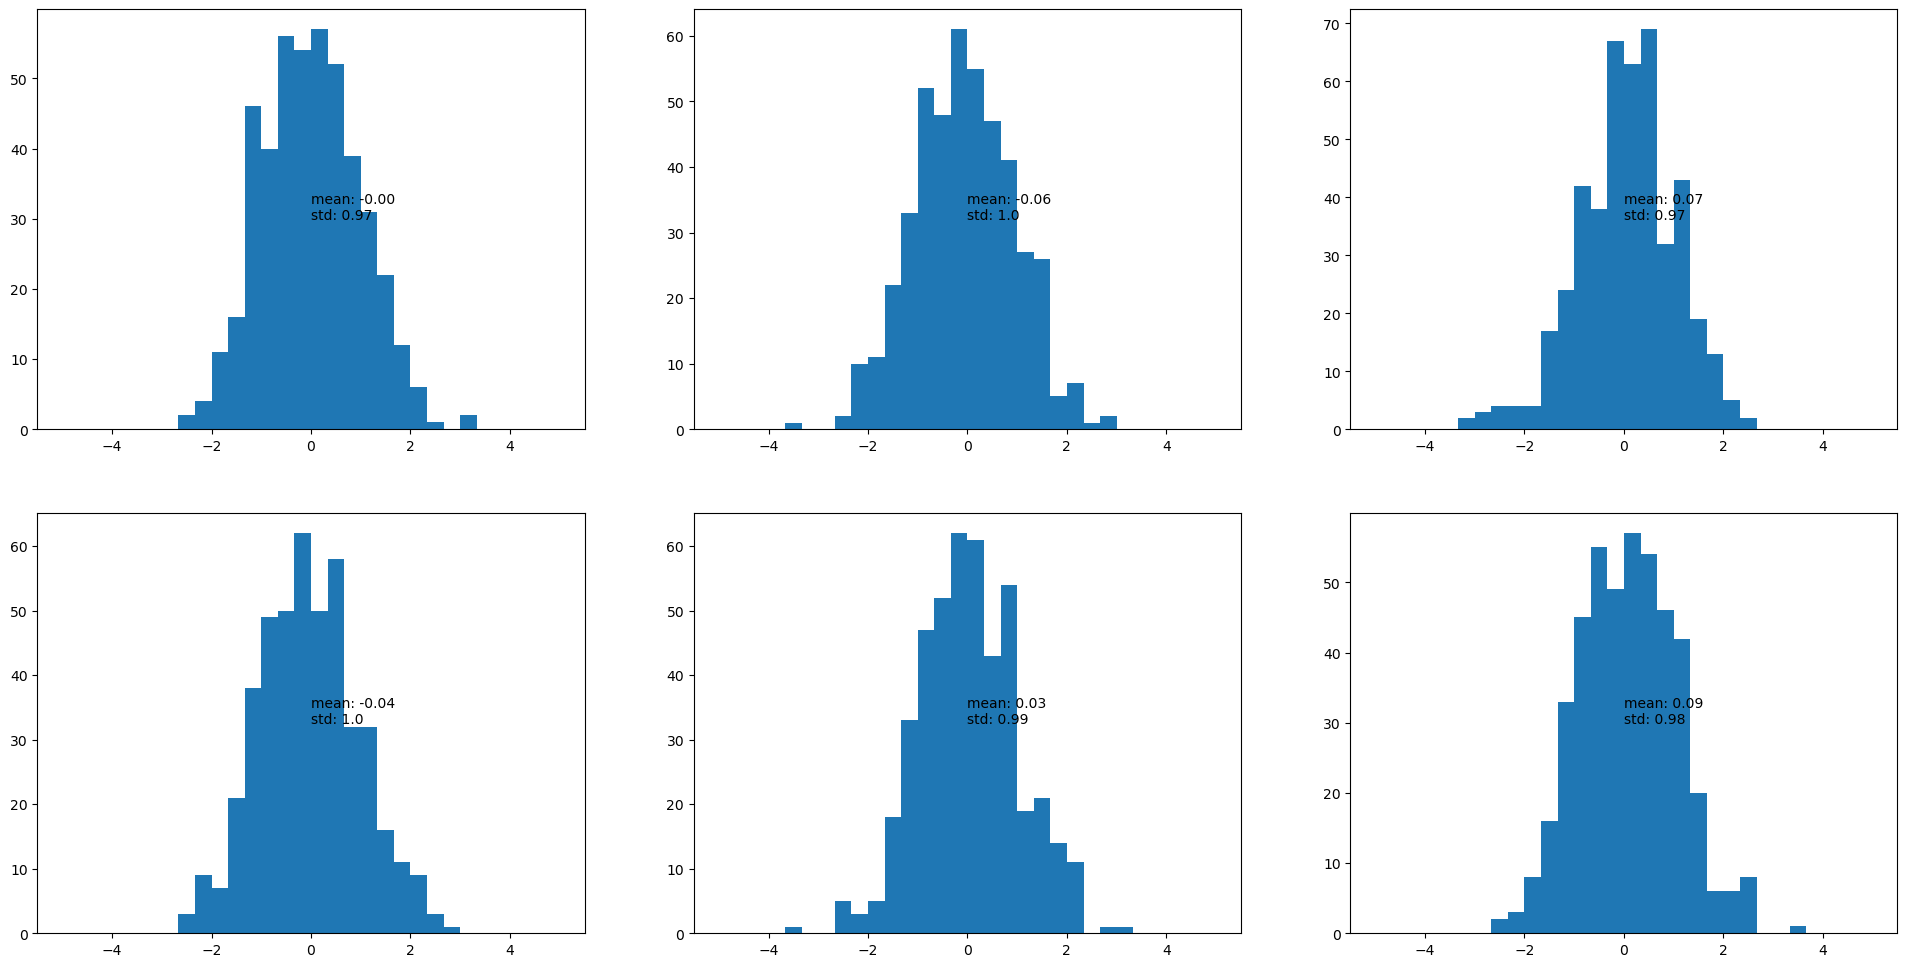

In [9]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(8*3, 6*2))

ax1.hist(xp_pull, bins=30, range=(-5, 5), label="x+")
ax1.text(0.5, 0.5, f"mean: {np.mean(xp_pull):.2f}\nstd: {np.std(xp_pull):.2f}", transform=ax1.transAxes)

ax2.hist(yp_pull, bins=30, range=(-5, 5), label="y+")
ax2.text(0.5, 0.5, f"mean: {np.mean(yp_pull):.2f}\nstd: {np.std(yp_pull):.2}", transform=ax2.transAxes)

ax3.hist(xm_pull, bins=30, range=(-5, 5), label="x-")
ax3.text(0.5, 0.5, f"mean: {np.mean(xm_pull):.2f}\nstd: {np.std(xm_pull):.2}", transform=ax3.transAxes)

ax4.hist(ym_pull, bins=30, range=(-5, 5), label="y-")
ax4.text(0.5, 0.5, f"mean: {np.mean(ym_pull):.2f}\nstd: {np.std(ym_pull):.2}", transform=ax4.transAxes)

ax5.hist(xxi_pull, bins=30, range=(-5, 5), label="xxi")
ax5.text(0.5, 0.5, f"mean: {np.mean(xxi_pull):.2f}\nstd: {np.std(xxi_pull):.2}", transform=ax5.transAxes)

ax6.hist(yxi_pull, bins=30, range=(-5, 5), label="yxi")
ax6.text(0.5, 0.5, f"mean: {np.mean(yxi_pull):.2f}\nstd: {np.std(yxi_pull):.2}", transform=ax6.transAxes)

In [8]:
import numpy as np

import matplotlib.pyplot as plt
import ROOT as r
import os
# Load the style file
from importlib.machinery import SourceFileLoader
r.gInterpreter.ProcessLine('#include "/software/pc24403/tfpcbpggsz/test/shenghuistyle.h"')


Welcome to JupyROOT 6.20/00


0

In [9]:
def do_fit(data, order=0, type="MD"):    

    title_latex = {'xPlus': 'x^{DK}_{+}', 'yPlus': 'y^{DK}_{+}', 'xMinus': 'x^{DK}_{-}', 'yMinus': 'y^{DK}_{-}', 'xXi': 'x^{D#pi}_{#xi}', 'yXi': 'y^{D#pi}_{#xi}'}
    # Define variable names and their corresponding RooRealVar objects
    variable_names = ['xPlus', 'yPlus', 'xMinus', 'yMinus', 'xXi', 'yXi']
    bound = {'xPlus':0.05, 'yPlus':0.05, 'xMinus':0.05, 'yMinus':0.05, 'xXi':0.1, 'yXi':0.1}
    variables = {}
    mean_var = {}
    sigma_var = {}
    for name in variable_names:
        if type == "pull":
            variables[name] = r.RooRealVar(f"pull_{name}", f"pull_{name}", -5, 5)
            mean_var[name] = r.RooRealVar(f"mean_{name}", f"mean_{name}", 0, -2, 2)
            sigma_var[name] = r.RooRealVar(f"sigma_{name}", f"sigma_{name}", 1, 0.1, 2.3)
        if type == "res":
            variables[name] = r.RooRealVar(f"res_{name}", f"res_{name}", -bound[name], bound[name])
            mean_var[name] = r.RooRealVar(f"mean_{name}", f"mean_{name}", 0, -1, 1)
            sigma_var[name] = r.RooRealVar(f"sigma_{name}", f"sigma_{name}", 1, 0.001, 1.3)

    
    # Define Gaussian PDFs for all four variables
    gaussians = {}
    for name in variable_names:
        gaussians[name] = r.RooGaussian(f"gaussian_{name}", f"gaussian_{name}", variables[name], mean_var[name], sigma_var[name])
    
    # Define RooFit data sets for all four variables
    pull_data = {}
    for name in variable_names:
        pull_data[name] = r.RooDataSet(f"pull_data_{name}", f"pull_data_{name}", r.RooArgSet(variables[name]))

    nsets = len(data['xPlus'])
    looping = len(data['xPlus'])
    looping_massfit = 0
    file_paths = []
    # Loop through the variables and perform fitting
    for index in range(1, 400+1):
        full_str=""
        file_paths.append(f"/dice/users/pc24403/BPGGSZ/sim_fit/simfit_output_{index}.txt")
        config = SourceFileLoader('config', '/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/config/lhcb/1x/%s'%(f'config_cpfit_output_{index}.py')).load_module()
        varDict = config.getconfig()
        if varDict['Status'] == 0:
            looping_massfit+=1


    print('INFO: Totally {} files Loaded'.format(len(file_paths)))

    for var_str in variable_names:
        for each_data in data[var_str]:
            variables[var_str].setVal(each_data)
            pull_data[var_str].add(r.RooArgSet(variables[var_str]))
    
    
    print('INFO: Data Loaded do Fit next')

    # Create a Canvas and plot the results
    r.lhcbStyle()
    canvas = r.TCanvas("canvas", "Pull Data", 800*3, 600*2)
    canvas.Divide(3, 2)
    label={}
    for i, name in enumerate(variable_names):
    
        gaussians[name].fitTo(pull_data[name])
        canvas.cd(i+1).SetTicks(1, 1)
        pull_plot = variables[name].frame()
        pull_data[name].plotOn(pull_plot, r.RooFit.Binning(30), r.RooFit.MarkerColor(r.kBlue), r.RooFit.LineColor(r.kPink+7))
        gaussians[name].plotOn(pull_plot, r.RooFit.LineColor(r.kAzure-1))
        pull_plot.SetXTitle(title_latex[name])
        pull_plot.Draw()
        # Create a TPaveText object
        mean_val = mean_var[name].getVal()
        mean_err = mean_var[name].getError()
        sigma_val = sigma_var[name].getVal()
        sigma_err = sigma_var[name].getError()
        str_mean = f"#mu: {mean_val:.2f}#pm{mean_err:.2f}"
        str_sigma = f"#sigma: {sigma_val:.2f}#pm{sigma_err:.2f}"
        if type=='res':
            mean_val = mean_val*100
            mean_err = mean_err*100
            sigma_val = sigma_val*100
            sigma_err = sigma_err*100
            str_mean = f"100#times#mu: {mean_val:.2f}#pm{mean_err:.2f}"
            str_sigma = f"100#times#sigma: {sigma_val:.2f}#pm{sigma_err:.2f}"
        label[name] = r.TPaveText(0.65, 0.7, 0.9, 0.85, "NDC")
        label[name].SetFillColor(0)
        label[name].SetBorderSize(0)
        label[name].AddText(str_mean)
        label[name].AddText(str_sigma)
        label[name].Draw()
        pull_plot.Draw("Same")
    
    
    canvas.SaveAs(f"/software/pc24403/tfpcbpggsz/{type}_plots_p{order}.pdf")
    #save the mean value into txt file
    #with open(f"pull_study/pull_plots{type}p{order}.txt", "w") as f:
    #    for name in variable_names:
    #        f.write(f"{name} {mean_var[name].getVal()} {mean_var[name].getError()}\n")
    #finished and clear all

    # Delete variables and free up memory
    for name in variable_names:
        del variables[name]
        del mean_var[name]
        del sigma_var[name]
        del pull_data[name]
        del gaussians[name]
        del label[name]

    # Close ROOT resources
    r.gROOT.GetListOfFunctions().Delete()
    r.gROOT.GetListOfSpecials().Delete()

    canvas.Clear()
    canvas.Close()
    print("Successful: Mass fit {:.3f}%".format(looping_massfit/nsets*100))
    print("Successful: CP fit {:.3f}%".format(looping/nsets*100))


In [10]:
#do_fit(pulls, 6, "pull")

In [11]:
#Use the dataframe calculate the correlation matrix and plot with seaborn
import seaborn as sns
import pandas as pd

df = pd.DataFrame(pulls)


In [12]:
correlation = df.corr()
print(correlation.T)

           xPlus     yPlus    xMinus    yMinus       xXi       yXi
xPlus   1.000000  0.173472 -0.024944  0.023106 -0.131049  0.020251
yPlus   0.173472  1.000000 -0.041588 -0.062067 -0.153775 -0.202445
xMinus -0.024944 -0.041588  1.000000 -0.161813  0.084197 -0.102970
yMinus  0.023106 -0.062067 -0.161813  1.000000  0.054611  0.109723
xXi    -0.131049 -0.153775  0.084197  0.054611  1.000000  0.057476
yXi     0.020251 -0.202445 -0.102970  0.109723  0.057476  1.000000


<Axes: >

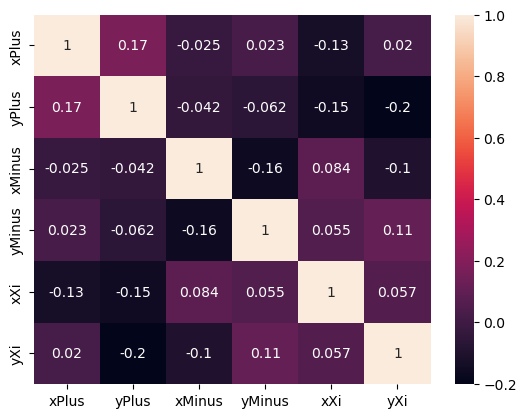

In [13]:
sns.heatmap(correlation.T, annot=True)

In [14]:
xp_res = []
yp_res = []
xm_res = []
ym_res = []
xxi_res = []
yxi_res = []

for i in range(len(xp)):
    xp_res.append((xp[i].n-x_exp[0]))
    yp_res.append((yp[i].n-x_exp[1]))
    xm_res.append((xm[i].n-x_exp[2]))
    ym_res.append((ym[i].n-x_exp[3]))
    xxi_res.append((xxi[i].n-x_exp[4]))
    yxi_res.append((yxi[i].n-x_exp[5]))

#Make it as dictionary
res = {
    "xPlus": xp_res,
    "yPlus": yp_res,
    "xMinus": xm_res,
    "yMinus": ym_res,
    "xXi": xxi_res,
    "yXi": yxi_res
}


In [15]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(8*3, 6*2))

ax1.hist(xp_res, bins=30, range=(-0.05, 0.05), label="x+")
ax1.text(0.5, 0.5, f"mean: {np.mean(xp_res):.2f}\nstd: {np.std(xp_res):.2f}", transform=ax1.transAxes)

ax2.hist(yp_res, bins=30, range=(-0.05, 0.05), label="y+")
ax2.text(0.5, 0.5, f"mean: {np.mean(yp_res):.2f}\nstd: {np.std(yp_res):.2}", transform=ax2.transAxes)

ax3.hist(xm_res, bins=30, range=(-0.05, 0.05), label="x-")
ax3.text(0.5, 0.5, f"mean: {np.mean(xm_res):.2f}\nstd: {np.std(xm_res):.2}", transform=ax3.transAxes)

ax4.hist(ym_res, bins=30, range=(-0.05, 0.05), label="y-")
ax4.text(0.5, 0.5, f"mean: {np.mean(ym_res):.2f}\nstd: {np.std(ym_res):.2}", transform=ax4.transAxes)

ax5.hist(xxi_res, bins=30, range=(-0.1, 0.1), label="xxi")
ax5.text(0.5, 0.5, f"mean: {np.mean(xxi_res):.2f}\nstd: {np.std(xxi_res):.2}", transform=ax5.transAxes)

ax6.hist(yxi_res, bins=30, range=(-0.1, 0.1), label="yxi")
ax6.text(0.5, 0.5, f"mean: {np.mean(yxi_res):.2f}\nstd: {np.std(yxi_res):.2}", transform=ax6.transAxes)

Text(0.5, 0.5, 'mean: 0.00\nstd: 0.018')

Error in callback <function flush_figures at 0x7fdc76db7f70> (for post_execute):


KeyboardInterrupt: 

In [ ]:
#do_fit(res, order=0, type="res")

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -3819                      │              Nfcn = 59               │
│ EDM = 1.22e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

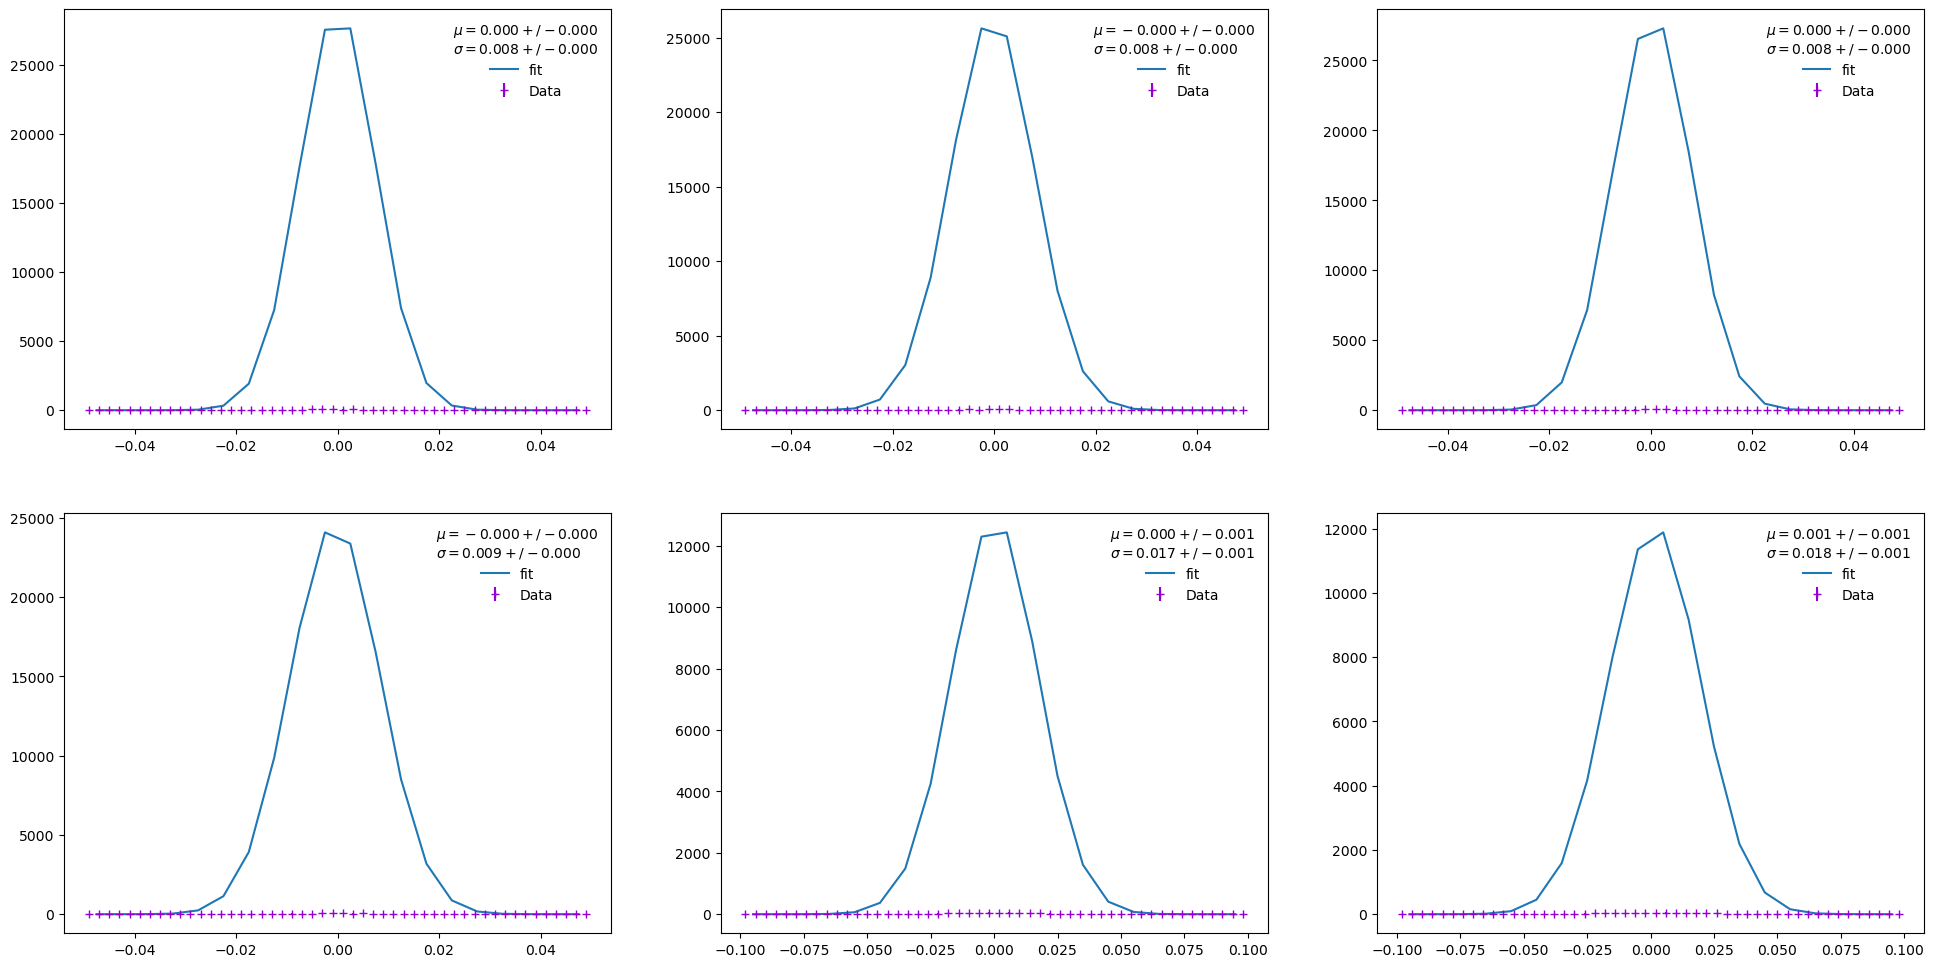

In [ ]:
#Fit with Gaussian with iminuit
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL

ax= [ax1, ax2, ax3, ax4, ax5, ax6]
bound = [0.05, 0.05, 0.05, 0.05, 0.1, 0.1]

fig, ((ax[0], ax[1], ax[2]), (ax[3], ax[4], ax[5])) = plt.subplots(2, 3, figsize=(8*3, 6*2))
i=0
for data in [xp_res, yp_res, xm_res, ym_res, xxi_res, yxi_res]:
    def pdf(x, mu, sigma):
        return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2/(2*sigma**2))
    
    c = UnbinnedNLL(data, pdf)
    
    m = Minuit(c, mu=0, sigma=0.01)
    m.migrad()
    m.hesse()
    print(m)
    
    w, xe = np.histogram(data, bins=20, range=(-bound[i], bound[i]))
    
    # compute bin-wise density estimates
    werr = w ** 0.5
    cx = 0.5 * (xe[1:] + xe[:-1])
    dx = np.diff(xe)
    d = w / dx
    derr = werr / dx

    bin_edges = np.linspace(-bound[i], bound[i], 50+1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    counts, _ = np.histogram(data, bins=bin_edges)

    std_devs = np.sqrt(counts)
    ax[i].errorbar(bin_centers, counts, yerr=std_devs, fmt='+', color='darkviolet', label='Data')        


    #ax[i].errorbar(cx, d, derr, fmt="o", label="data", zorder=0)
    ax[i].plot(cx, len(xp_pull)*pdf(cx, m.values[0], m.values[1]),
         label="fit")
    ax[i].legend(frameon=False,
           title=f"$\mu = {m.values[0]:.3f} +/- {m.errors[0]:.3f}$\n"
                 f"$\sigma = {m.values[1]:.3f} +/- {m.errors[1]:.3f}$");
    i+=1

In [ ]:

foundCKM = False
idx_CKM = 0
cov_string = ""
param_string = ""
log_strings = []
cov = []


for result_file in result_files:
    idx = 0
    cov_temp = []
    with open(result_file) as f:
        for l in f:
            for i_dex in range(0,6):
                if f"│  x{i_dex} │" in l:
                    a = l.split()
                    cov_CKM_row = []
                    for j_dex in range(0,6):
                        cov_CKM_row += [float(a[3+j_dex])]
                    cov_temp += [cov_CKM_row]

            log_strings += [l.replace("\n", "")]
        cov += cov_temp[0:6]



X = []
for i in range(len(xp)):
    X += [[xp[i].n, yp[i].n, xm[i].n, ym[i].n, xxi[i].n, yxi[i].n]]


In [ ]:
print(cov[6:12])

[[6.1e-05, 1.24e-05, -7.93e-07, -1.6e-06, -2.37e-05, -6.52e-06], [1.24e-05, 6.61e-05, 1.47e-06, -1.79e-06, -3.72e-06, -1.65e-05], [-7.93e-07, 1.47e-06, 6.01e-05, -1.07e-05, 1.22e-05, -2.49e-05], [-1.6e-06, -1.79e-06, -1.07e-05, 7.93e-05, 1.14e-05, 2.62e-05], [-2.37e-05, -3.72e-06, 1.22e-05, 1.14e-05, 0.000233, 2.12e-05], [-6.52e-06, -1.65e-05, -2.49e-05, 2.62e-05, 2.12e-05, 0.000254]]


In [ ]:

def deg_to_rad(deg):
    return deg*np.pi/180

def rad_to_deg(rad):
    return rad*180/np.pi

def get_correlation_matrix(cov_matrix):
    corr_matrix = cov_matrix*0
    n = np.shape(cov_matrix)[0]
    for i in range(0, n):
        for j in range(0, n):
            corr_matrix[i, j] = cov_matrix[i, j]/math.sqrt(cov_matrix[i, i]*cov_matrix[j, j])
    return corr_matrix

def add_fit_result_details(res, data, H):
    
    # add the same results as in the yield fits
    ndf = len(data)-6
    res.p_value = 1 - stats.chi2.cdf(2*res.fun, ndf)

    res.H = H

    res.cov_mat = np.linalg.inv(res.H)
    try:
        res.cor_mat = get_correlation_matrix(res.cov_mat)
    except ValueError:
        # something went wrong when inverting
        # negative elements in covariance matrix diag
        # don't trust results
        res.success = False
        res.cor_mat = 0 * H
    res.x_unc = np.sqrt(np.diag(res.cov_mat))

    # translate to degrees; 1st save raw results
    res.raw_x = np.copy(res.x)
    res.raw_x_unc = np.copy(res.x_unc)

    # ensure angles are positive
    while res.x[0] < 0: res.x[0] += 2*math.pi
    while res.x[2] < 0: res.x[2] += 2*math.pi

    for i in range(len(res.x)):
        if (i % 2) == 0:
            # every other result is an angle, so apply rad_to_deg
            res.x[i] = rad_to_deg(res.x[i])
            res.x_unc[i] = rad_to_deg(res.x_unc[i])

    return res

In [ ]:
# Chi2 residual for Parameters to fit: r, delta, gamma

def xm(rB, deltaB, gamma):
    xm = rB*np.cos(deltaB - gamma)
    return xm

def xp(rB, deltaB, gamma):
    xp = rB*np.cos(deltaB + gamma)
    return xp

def ym(rB, deltaB, gamma):
    ym = rB*np.sin(deltaB - gamma)
    return ym

def yp(rB, deltaB, gamma):
    yp = rB*np.sin(deltaB + gamma)
    return yp

def x_xi(rB, deltaB, rB_DPi, deltaB_DPi):
    x_xi = rB_DPi/rB*np.cos(deltaB_DPi - deltaB)
    return x_xi

def y_xi(rB, deltaB, rB_DPi, deltaB_DPi):
    y_xi = rB_DPi/rB*np.sin(deltaB_DPi - deltaB)
    return y_xi

def get_xy_xi(physics_param):
    ''' takes an input vector with [gamma, rB, deltaB] and returns x, y
    angles in RADIANS
    '''
    gamma  = physics_param[0]
    r_dk   = physics_param[1]
    d_dk   = physics_param[2]
    r_dpi  = physics_param[3]
    d_dpi  = physics_param[4]

    xp = r_dk * np.cos(d_dk + gamma)
    xm = r_dk * np.cos(d_dk - gamma)
    ym = r_dk * np.sin(d_dk - gamma)
    yp = r_dk * np.sin(d_dk + gamma)

    x_xi = (r_dpi/r_dk)*np.cos(d_dpi-d_dk)
    y_xi = (r_dpi/r_dk)*np.sin(d_dpi-d_dk)

    return [xp, yp, xm, ym,  x_xi, y_xi]

In [ ]:

def fit(xy_xi_vector, xy_xi_cov_mat, start_guess =  [deg_to_rad(75.), 0.1, deg_to_rad(130.), 0.005, deg_to_rad(230.)]):

    xy_xi_cov_mat_inv = np.linalg.inv(xy_xi_cov_mat) # covariance matrix

    # bound r's to be positive
    bounds = [(0, math.pi), 
        (1e-5, None), (None, None),
        (1e-5, None), (None, None)]

    res = minimize(chi_square_func_for_xy_xi, 
        start_guess, 
        (xy_xi_vector, xy_xi_cov_mat_inv),
        method = 'L-BFGS-B',
        bounds=bounds)

    H_func = hessian(chi_square_func_for_xy_xi)
    H = H_func(np.array(res.x), xy_xi_vector, xy_xi_cov_mat_inv)

    res = add_fit_result_details(res, xy_xi_vector,  H)

    return res.x, res.x_unc, res

def chi_square_func_for_xy_xi(physics_param, *args):
    ''' chi square for physics param = [xm, ym, xp, yp, x_xi, y_xi]'''
    xy_xi_vector = args[0]
    xy_xi_cov_mat_inv = args[1]
    fit_xy_xi_vector = np.array(get_xy_xi(physics_param))
    dx = xy_xi_vector - fit_xy_xi_vector
    chi_square = 0.5*np.dot(
        np.dot(dx.transpose(),xy_xi_cov_mat_inv),
        dx)
    return chi_square 

def add_fit_result_details(res, data, H):
    
    # add the same results as in the yield fits
    ndf = len(data)-6
    res.p_value = 1 - stats.chi2.cdf(2*res.fun, ndf)

    res.H = H

    res.cov_mat = np.linalg.inv(res.H)
    try:
        res.cor_mat = get_correlation_matrix(res.cov_mat)
    except ValueError:
        # something went wrong when inverting
        # negative elements in covariance matrix diag
        # don't trust results
        res.success = False
        res.cor_mat = 0 * H
    res.x_unc = np.sqrt(np.diag(res.cov_mat))

    # translate to degrees; 1st save raw results
    res.raw_x = np.copy(res.x)
    res.raw_x_unc = np.copy(res.x_unc)

    # ensure angles are positive
    while res.x[0] < 0: res.x[0] += 2*math.pi
    while res.x[2] < 0: res.x[2] += 2*math.pi

    for i in range(len(res.x)):
        if (i % 2) == 0:
            # every other result is an angle, so apply rad_to_deg
            res.x[i] = rad_to_deg(res.x[i])
            res.x_unc[i] = rad_to_deg(res.x_unc[i])

    return res

In [ ]:
result = []
for i in range(500):
    result.append(fit(X[i], cov[i*6:6*(i+1)]))

TypeError: loop of ufunc does not support argument 0 of type ArrayBox which has no callable cos method

In [ ]:
gamma = []
dB_dk = []
rB_dk = []
rB_dpi = []
dB_dpi = []
for i in range(100):
    gamma.append(result[i][0][0])
    rB_dk.append(result[i][0][1])
    dB_dk.append(result[i][0][2])
    rB_dpi.append(result[i][0][3])
    dB_dpi.append(result[i][0][4])

Text(0.5, 0.4, 'Input: 291')

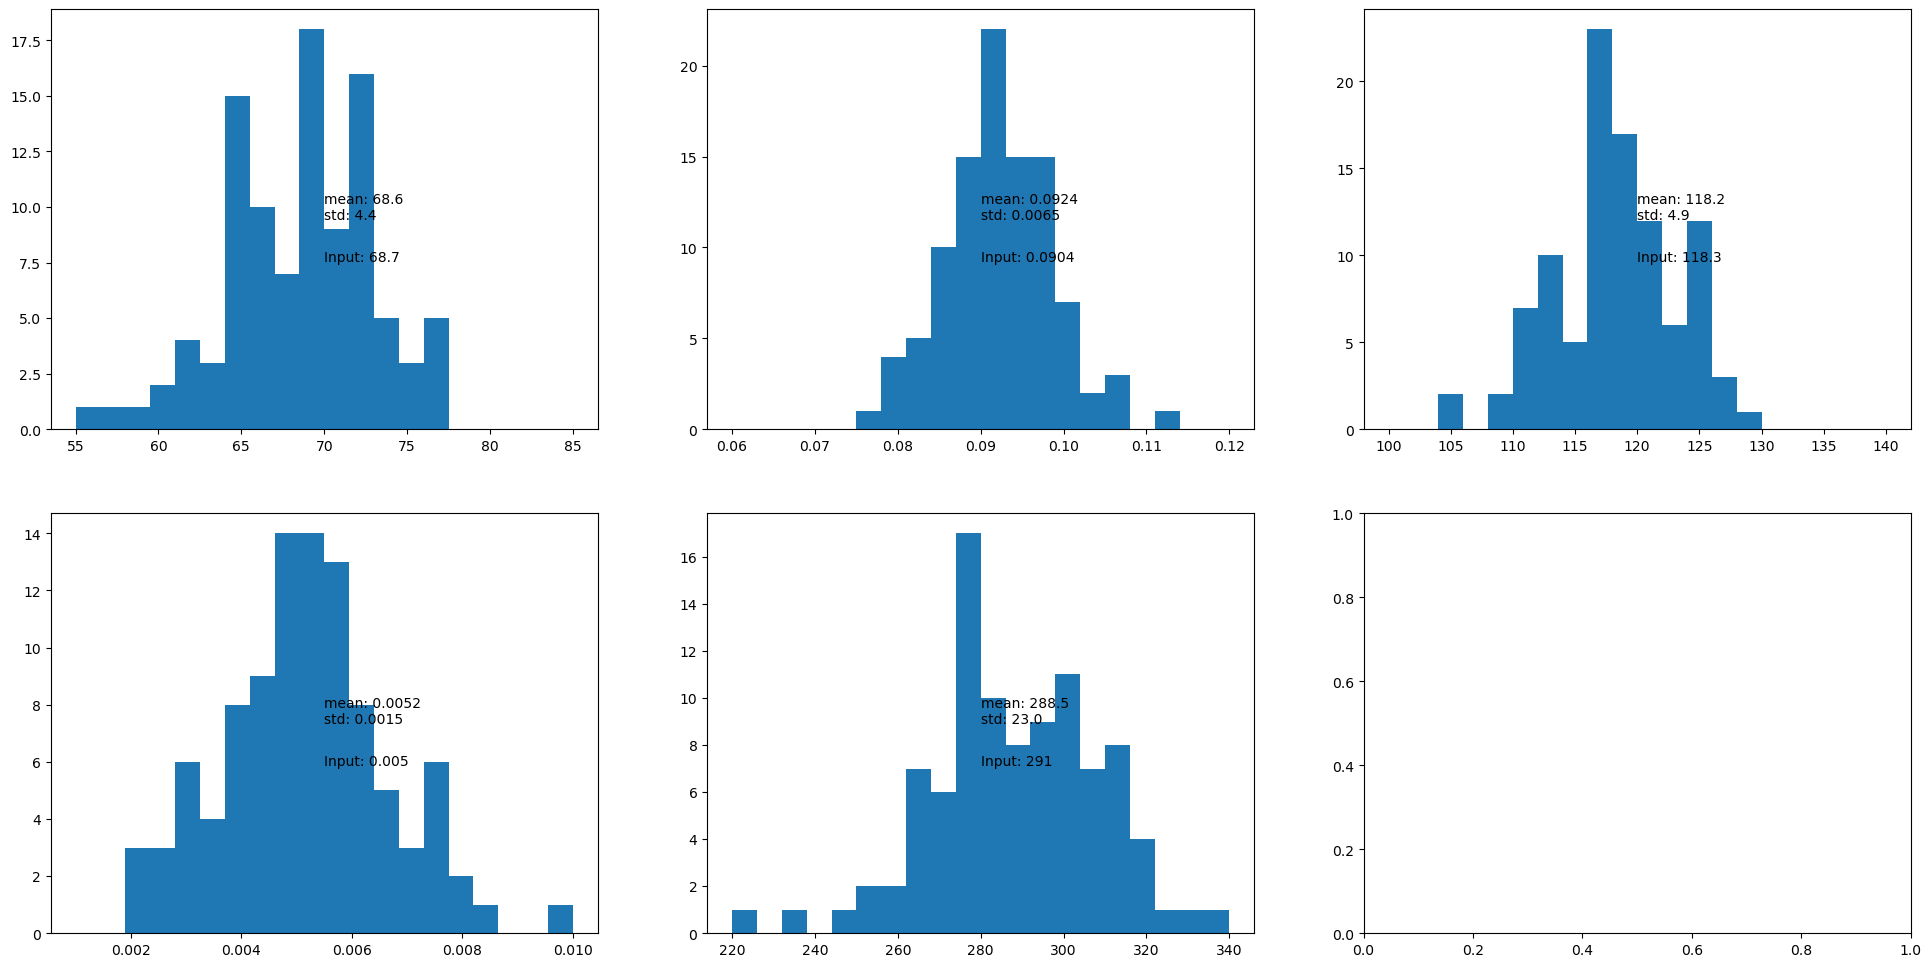

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(8*3, 6*2))

ax1.hist(gamma, bins=20, range=(55, 85), label="gamma")
ax1.text(0.5, 0.5, f"mean: {np.mean(gamma):.1f}\nstd: {np.std(gamma):.1f}",
            transform=ax1.transAxes)
ax1.text(0.5, 0.4, "Input: 68.7", transform=ax1.transAxes)

ax2.hist(rB_dk, bins=20, range=(0.06, 0.12), label="rB_dk")
ax2.text(0.5, 0.5, f"mean: {np.mean(rB_dk):.4f}\nstd: {np.std(rB_dk):.4f}",
            transform=ax2.transAxes)
ax2.text(0.5, 0.4, "Input: 0.0904", transform=ax2.transAxes)

ax3.hist(dB_dk, bins=20, range=(100, 140), label="dB_dk")
ax3.text(0.5, 0.5, f"mean: {np.mean(dB_dk):.1f}\nstd: {np.std(dB_dk):.1f}",
            transform=ax3.transAxes)
ax3.text(0.5, 0.4, "Input: 118.3", transform=ax3.transAxes)


ax4.hist(rB_dpi, bins=20, range=(0.001, 0.01), label="rB_dpi")
ax4.text(0.5, 0.5, f"mean: {np.mean(rB_dpi):.4f}\nstd: {np.std(rB_dpi):.4f}",
            transform=ax4.transAxes)
ax4.text(0.5, 0.4, "Input: 0.005", transform=ax4.transAxes)

ax5.hist(dB_dpi, bins=20, range=(220, 340), label="dB_dpi")
ax5.text(0.5, 0.5, f"mean: {np.mean(dB_dpi):.1f}\nstd: {np.std(dB_dpi):.1f}",
            transform=ax5.transAxes)
ax5.text(0.5, 0.4, "Input: 291", transform=ax5.transAxes)


